# Other Manufacturing Sources Profiling
_Profiling attempts to distinguish the different potential sources of PFAS attribution to our private well supplies. The way that we can create a profile of a potential source is by ingesting sampling results (that are most directly attributable to a specific source) through a feature reduction or clustering method to build a vector/model that exemplifies that source._ 

**PCA** is used in this notebook to build a profile of the potential sources.
**HC (or HCA)** (hierarchical clustering analysis) is used in conjunction with PCA to build profile(s).

Potential Sources & attributable information:
* Residential Profile: Wastewater/sludge data from wastewater treatment systems (in a separate notebook)
  (residential_profiling.ipynb)
* AFFF Profile: AFFF lab reports (AFFF_profiling.ipynb)
* Other manufacturing sources: Disposal site groundwater supplies (THIS notebook)
    * Each eigenvector may indicate a different potential industry/manufacturing source
    * Additional spatial inference may need to be employed to identify the types of sources attributed to each eigenvector
    
EDA is used to understand the general trends of the profiles to intuitively understand the results of the analysis. Geospatial inferencing is additionally employed to further understand the landscape of the potential source effects.

****

Questions to consider:

- How will we use spatial inference to infer the eigenvectors?
    * Use maps and general distances to understand potential impacts. Possibly highlight a few places with high PFAS levels and nearby contaminant sources.
    * Maybe only use for Hierarchical clustering

Notes/Assumptions/Decisions about analysis
* Matrix and dilution factors need to be accounted for in AFFF data before normalization.
* Partition liquid v. water in normalization

***

In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

## Import Data
* Data has already been imputed via imputation pipeline

In [2]:
other_df = pd.read_csv('../../../data/modeling_data/source_attribution/other_source.csv')

In [3]:
pfas18 = pd.read_csv('../../../data/Extracted lab report data/PFAS_compounds.csv')[['Acronym','PFAS18']]
pfas18 = pfas18[~(pfas18['PFAS18'].isna())]['Acronym']

In [4]:
pfas_vars = utils.get_pfas_vars(df = other_df,
                                pfas18 = pfas18)

Normalize. Make sure the ingested data is z-score normalized

In [5]:
# other_df.columns

In [6]:
other_df_eda = utils.normalize_over_partitions(df = other_df, 
                                              pfas_vars = pfas_vars,
                                              units_col = 'Units',
                                              scaler_fn = 'MinMax')

## EDA

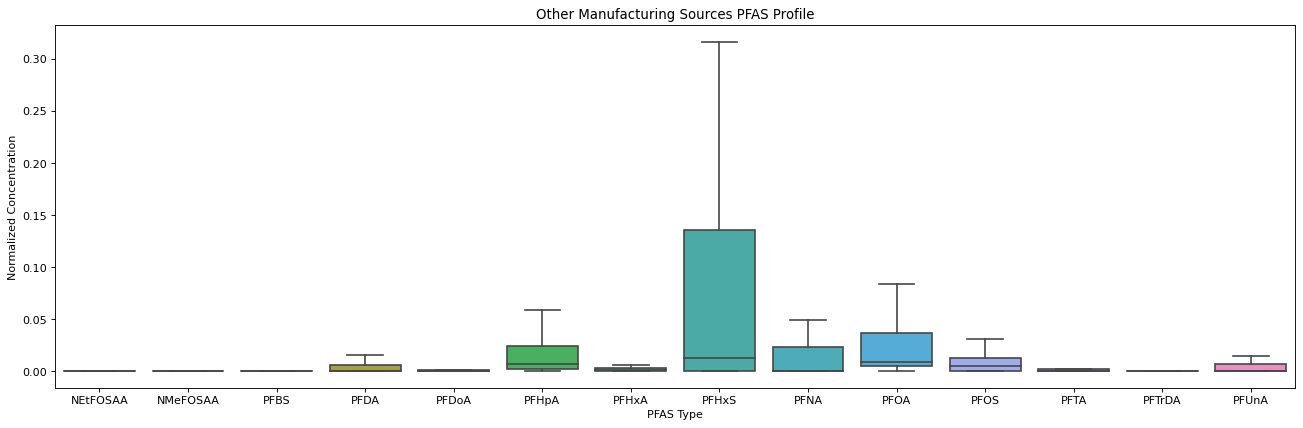

In [7]:
# Should this be in molecular weight order?? - Easier to compare across different sources/samples

plt.figure(figsize=(20, 6), dpi=80)
plt.title('Other Manufacturing Sources PFAS Profile')

# pd.melt(other_df[pfas_vars])
sns.boxplot(x="variable", y="value", data=pd.melt(other_df_eda[pfas_vars]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

## PCA
* We should use enough eigenvectors to explain 70% of the variance, or up to 2 eigenvectors for each potential source.
* 18 v. 6 analysis: https://www.youtube.com/watch?v=d588GFOEnP0

In [8]:
from sklearn.decomposition import PCA

In [9]:
other_df = utils.normalize_over_partitions(df = other_df, 
                                          pfas_vars = pfas_vars,
                                          units_col = 'Units',
                                          scaler_fn = 'Zscore')

In [10]:
other_df.head(10)

,Unnamed: 0,report,date_sampled,sample_id,lab,Matrix,Units,NEtFOSAA,NMeFOSAA,PFBS,...,PFDoA,PFHpA,PFHxA,PFHxS,PFNA,PFOA,PFOS,PFTA,PFTrDA,PFUnA
0,0,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 13:12,01G,Alpha,Dw,ng/l,2.167701,-0.243888,-0.099735,...,-0.141715,-0.249675,-0.186547,-0.274206,-0.280547,-0.283648,1.274752,-0.145476,-0.155451,-0.171878
1,1,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 13:29,02G,Alpha,Dw,ng/l,-0.256939,-0.243888,-0.099632,...,-0.141715,-0.281517,-0.187068,-0.264395,-0.298794,-0.378051,-0.302491,-0.145476,-0.155451,-0.171878
2,2,1-0021230 - Lanesborough - Document_ID_587486 ...,12/27/18 10:10,PROPERTY CS,Alpha,Dw,ng/l,-0.256939,-0.243888,-0.099735,...,-0.141715,-0.170025,-0.164003,-0.287487,-0.298794,-0.359590,-0.327860,-0.145476,-0.155451,-0.171878
3,3,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 10:32,TW-7,Alpha,Water,ng/l,-0.256939,-0.243888,-0.099670,...,-0.141715,-0.273604,-0.185256,-0.264232,-0.263783,-0.365831,-0.140237,-0.145476,-0.155451,-0.171878
4,4,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 13:12,01G,Alpha,Water,ng/l,-0.256939,-0.243888,-0.099735,...,-0.141715,-0.250187,-0.186332,-0.280169,-0.291186,-0.285221,1.261699,-0.145476,-0.155451,-0.171878
5,5,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 13:29,02G,Alpha,Water,ng/l,-0.256939,-0.243888,-0.099652,...,-0.141715,-0.284936,-0.187457,-0.279681,-0.298794,-0.379624,-0.303796,-0.145476,-0.155451,-0.171878
6,6,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 00:00,TW-1,Alpha,Water,ng/l,-0.256939,-0.243888,-0.099735,...,-0.141715,-0.270698,-0.188011,-0.278109,-0.298794,-0.329276,0.109083,-0.145476,-0.155451,-0.171878
7,7,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 00:00,TW-1-A,Alpha,Water,ng/l,-0.256939,-0.243888,-0.099727,...,-0.141715,-0.210363,-0.186351,-0.221950,-0.298794,-0.157253,0.171739,-0.145476,-0.155451,-0.171878
8,8,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 00:00,TW-4,Alpha,Water,ng/l,-0.256939,-0.243888,-0.099720,...,-0.141715,-0.290534,-0.188620,-0.287487,-0.298794,-0.386489,-0.327860,-0.145476,-0.155451,-0.171878
9,9,1-0021230 - Lanesborough - Document_ID_587486 ...,01/08/21 00:00,TW-4-A,Alpha,Water,ng/l,-0.256939,-0.243888,-0.099718,...,-0.141715,-0.268818,-0.186332,-0.275399,-0.264815,-0.367352,-0.315675,-0.145476,-0.155451,-0.171878


In [11]:
# Need to remove remaining NaNs. Not sure how to do that yet. Might need to substitute
# known reporting limit for that lab for the particular compound? Dropping columns with NaNs will eliminate many of
# the compounds and result in errors later on.
# residential_df.dropna(inplace = True)
# other_df.dropna(axis = 'columns', inplace = True)
# other_df.fillna(value = 0.0, inplace = True)

In [12]:
# other_df.head(10)

In [13]:
# residential_df = afff_df

# pca = PCA()
# pca
pca = PCA(n_components=6)
Principal_components=pca.fit_transform(other_df[pfas_vars])
# print(Principal_components.shape)
pca_df = pd.DataFrame(data = Principal_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'])

component_matrix = pca.components_
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [14]:
import pickle as pk
# Save PCA for source attribution
# pk.dump(pca, open("./results/afff_pca.pkl", "wb"))

### Visualization

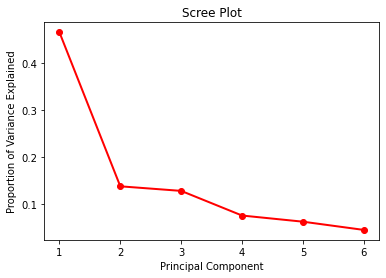

In [15]:
# Examine PCA results - scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [16]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)  
    
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.46662045 0.13748368 0.12770965 0.07507188 0.06191632 0.04433543]
Cumulative Prop. Variance Explained:  [0.46662045 0.60410413 0.73181378 0.80688566 0.86880198 0.91313742]


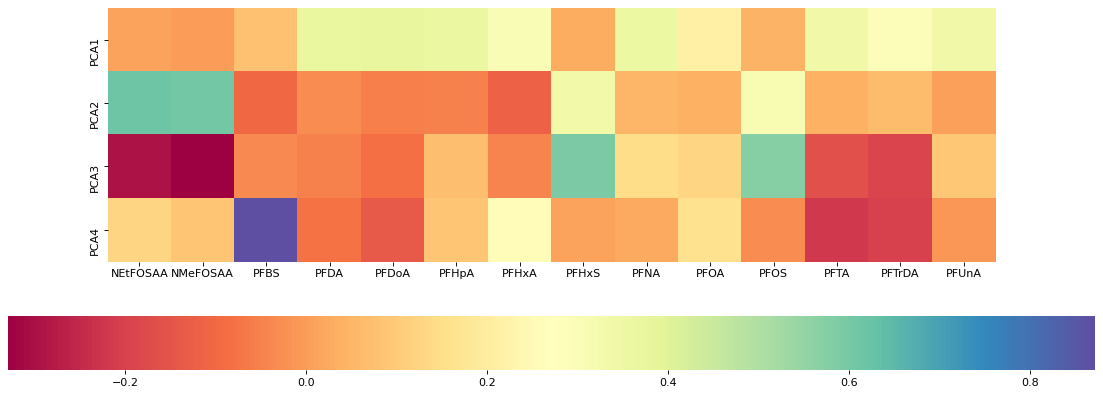

In [17]:
# look at correlation matrix of components
plt.figure(figsize=(20, 6), dpi=80)

ax = sns.heatmap(component_matrix[:4],
                 cmap='Spectral',
                 yticklabels=[ "PCA"+str(x) for x in range(1,4+1)],
                 xticklabels=list(other_df[pfas_vars].columns),
                 cbar_kws={"orientation": "horizontal"})

ax.set_aspect("equal")

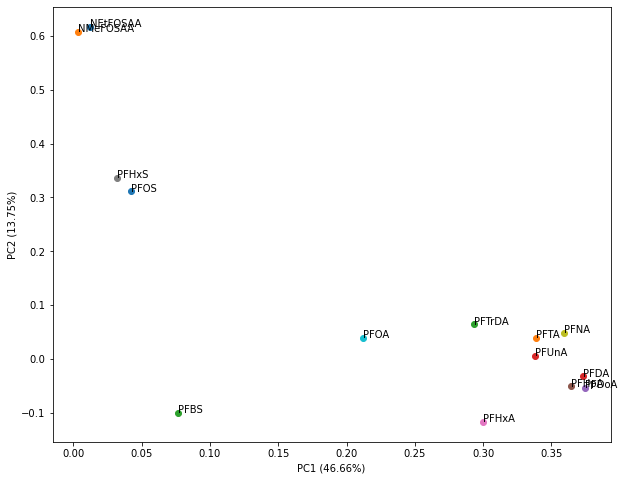

In [18]:
utils.pcaplot(x=component_matrix[0], y=component_matrix[1], labels=other_df[pfas_vars].columns.values, 
    var1=round(pca.explained_variance_ratio_[0]*100, 2),
    var2=round(pca.explained_variance_ratio_[1]*100, 2),
             dim=(10, 8))

In [19]:
# 3D
# cluster.pcaplot(x=loadings[0], y=loadings[1], z=loadings[2],  labels=df.columns.values, 
#     var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
#     var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

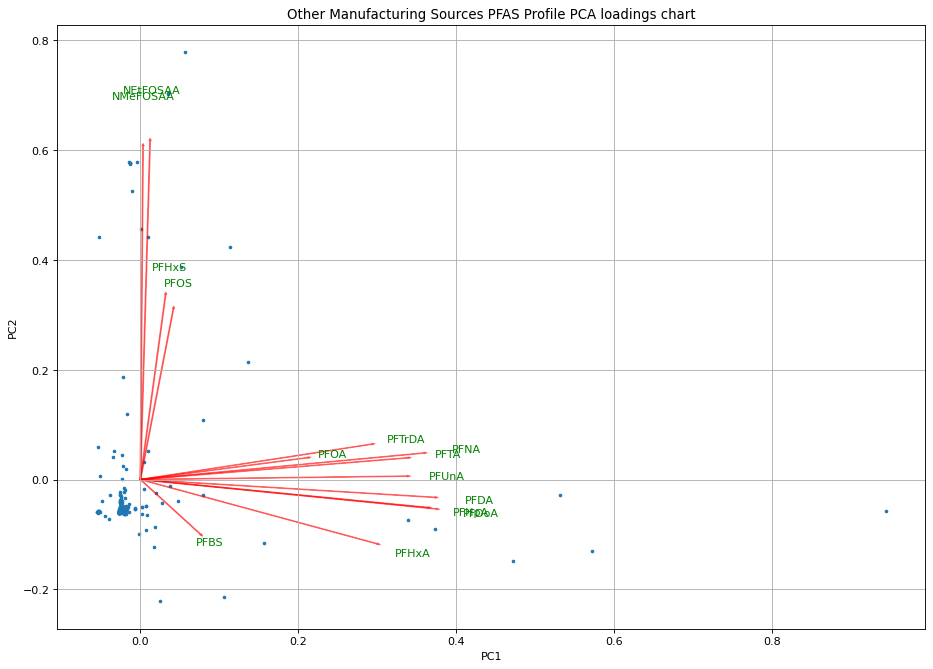

In [20]:
utils.pca_loadings_plot(Principal_components[:,0:2],np.transpose(pca.components_[0:2, :]),list(other_df[pfas_vars].columns), title = "Other Manufacturing Sources PFAS Profile PCA loadings chart")

In [21]:
pca_df_x = pca_df.iloc[:,0]
pca_df_y = pca_df.iloc[:,1]
pca_df_z = pca_df.iloc[:,2]
scalex = 1.0/(pca_df_x.max() - pca_df_x.min())
scaley = 1.0/(pca_df_y.max() - pca_df_y.min())
scalez = 1.0/(pca_df_z.max() - pca_df_z.min())

In [22]:
other_df['RTN'] = other_df['report'].str[:9]

In [23]:
other_df['RTN'].unique()

array(['1-0021230', '2-0020439', '2-0021116', '2-0021349', '2-0021383',
       '2-0021446', '2-0021455', '2-0021541', '3-0036649', '3-0036899',
       '3-0036926', '4-0028330', '2-0021682'], dtype=object)

In [28]:
other_df = other_df.reset_index()

In [29]:
pca_df['RTN'] = other_df['RTN']

1-0021230
PC 1 Score Summary Statistics : count    15.000000
mean     -0.026103
std       0.001968
min      -0.027557
25%      -0.027553
50%      -0.027244
75%      -0.025544
max      -0.021588
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    15.000000
mean     -0.036695
std       0.063717
min      -0.061644
25%      -0.060664
50%      -0.059570
75%      -0.047866
max       0.185901
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    15.000000
mean     -0.010432
std       0.022840
min      -0.022646
25%      -0.022640
50%      -0.020846
75%      -0.006258
max       0.062644
Name: PC 3, dtype: float64


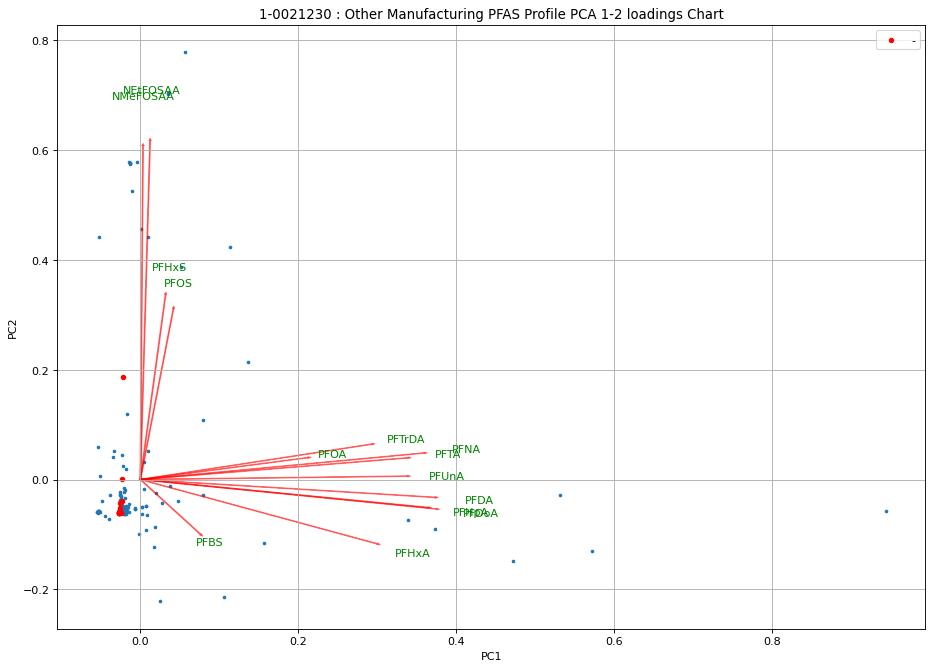

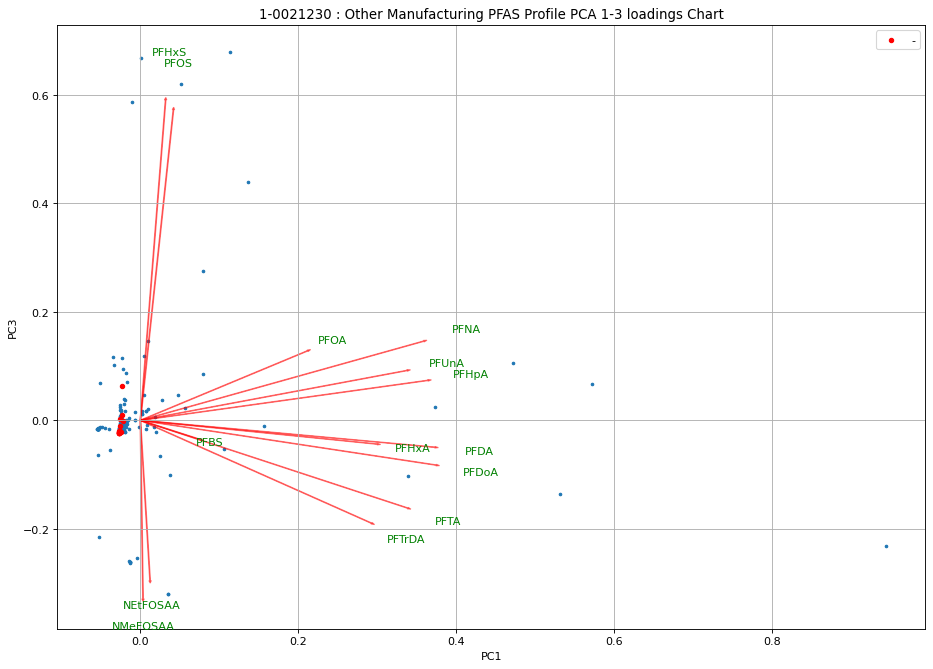

2-0020439
PC 1 Score Summary Statistics : count    18.000000
mean     -0.002477
std       0.028697
min      -0.025509
25%      -0.023615
50%      -0.012078
75%       0.005409
max       0.078948
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    18.000000
mean     -0.051360
std       0.008252
min      -0.059967
25%      -0.057212
50%      -0.053460
75%      -0.048552
max      -0.027738
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    18.000000
mean      0.005235
std       0.027805
min      -0.019951
25%      -0.012776
50%      -0.003298
75%       0.015133
max       0.084814
Name: PC 3, dtype: float64


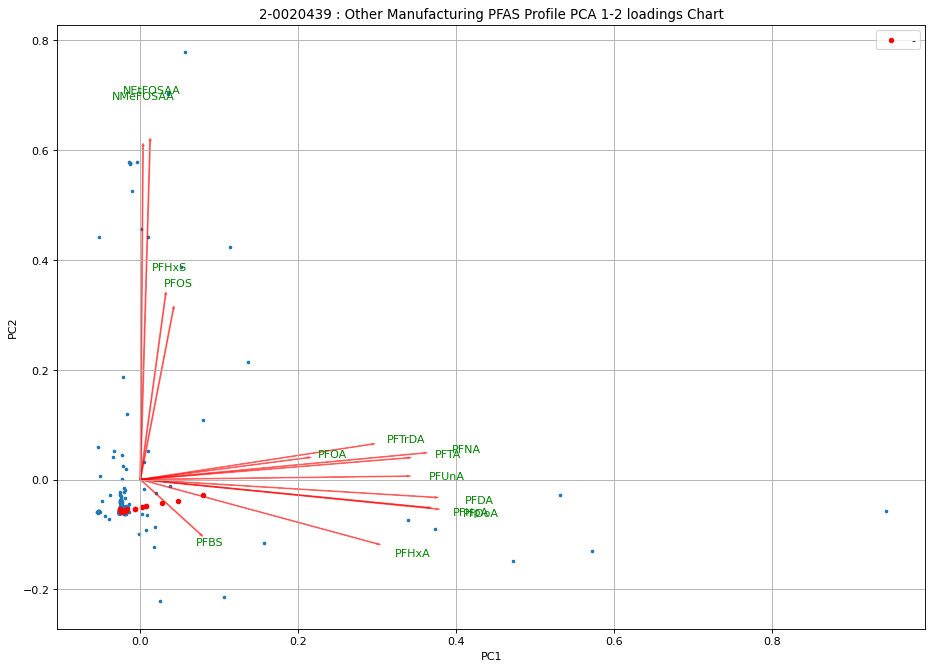

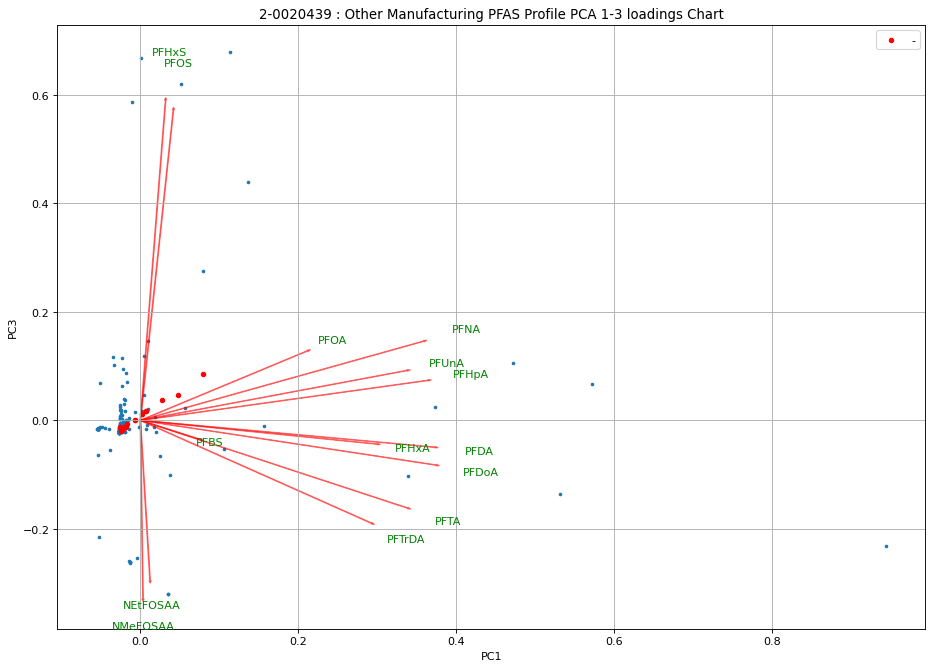

2-0021116
PC 1 Score Summary Statistics : count    6.000000
mean    -0.012251
std      0.003672
min     -0.014386
25%     -0.013694
50%     -0.013589
75%     -0.013469
max     -0.004787
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    6.000000
mean     0.576193
std      0.001175
min      0.574998
25%      0.575582
50%      0.575619
75%      0.577038
max      0.577840
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    6.000000
mean    -0.259823
std      0.003150
min     -0.262202
25%     -0.261398
50%     -0.261232
75%     -0.259603
max     -0.253758
Name: PC 3, dtype: float64


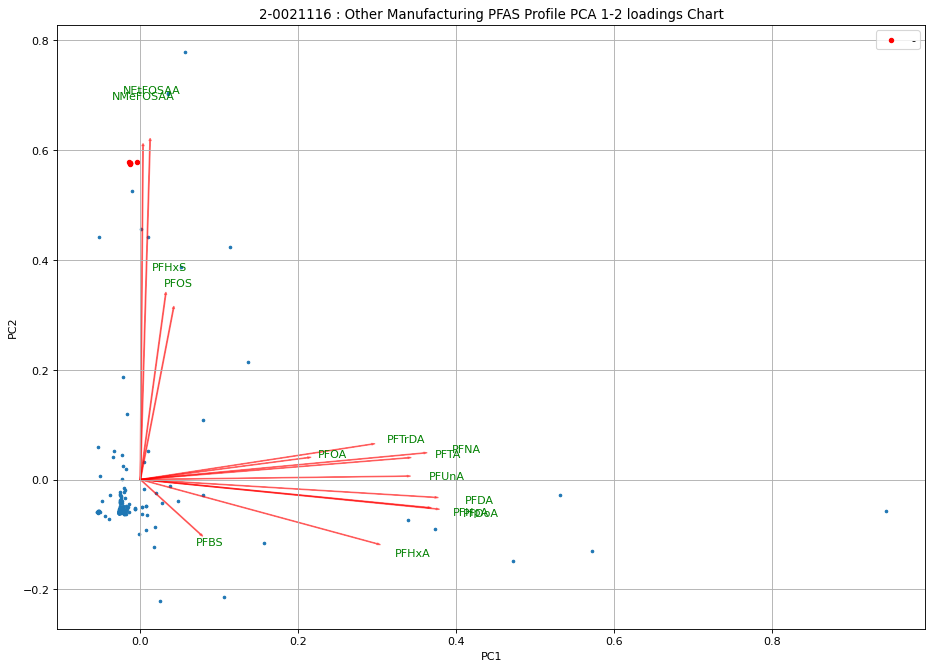

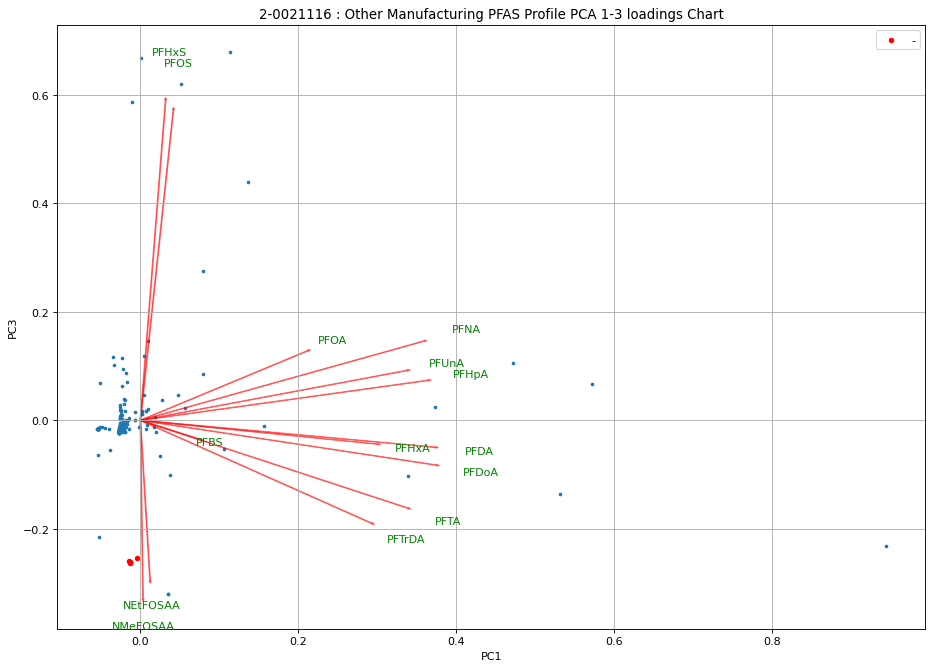

2-0021349
PC 1 Score Summary Statistics : count    20.000000
mean     -0.022231
std       0.014329
min      -0.027323
25%      -0.026699
50%      -0.025989
75%      -0.024963
max       0.038030
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    20.000000
mean     -0.054042
std       0.010557
min      -0.062059
25%      -0.059105
50%      -0.056528
75%      -0.052569
max      -0.012356
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    20.000000
mean     -0.019420
std       0.019912
min      -0.101453
25%      -0.019896
50%      -0.016000
75%      -0.010989
max      -0.006660
Name: PC 3, dtype: float64


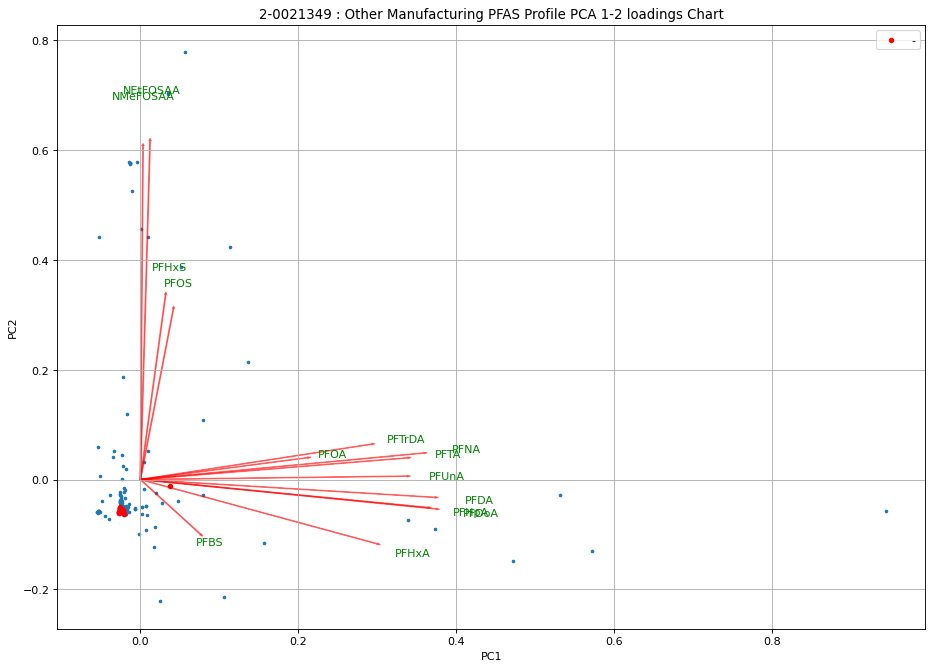

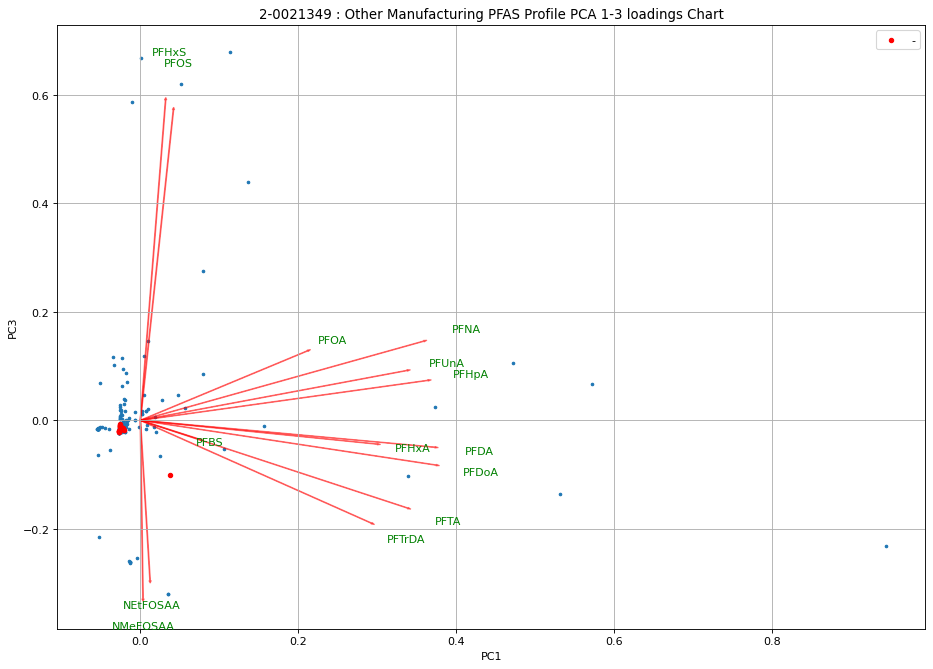

2-0021383
PC 1 Score Summary Statistics : count    2.000000
mean     0.035204
std      0.000375
min      0.034939
25%      0.035071
50%      0.035204
75%      0.035337
max      0.035470
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    2.000000
mean     0.703189
std      0.000465
min      0.702861
25%      0.703025
50%      0.703189
75%      0.703354
max      0.703518
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    2.000000
mean    -0.320446
std      0.000834
min     -0.321035
25%     -0.320741
50%     -0.320446
75%     -0.320151
max     -0.319856
Name: PC 3, dtype: float64


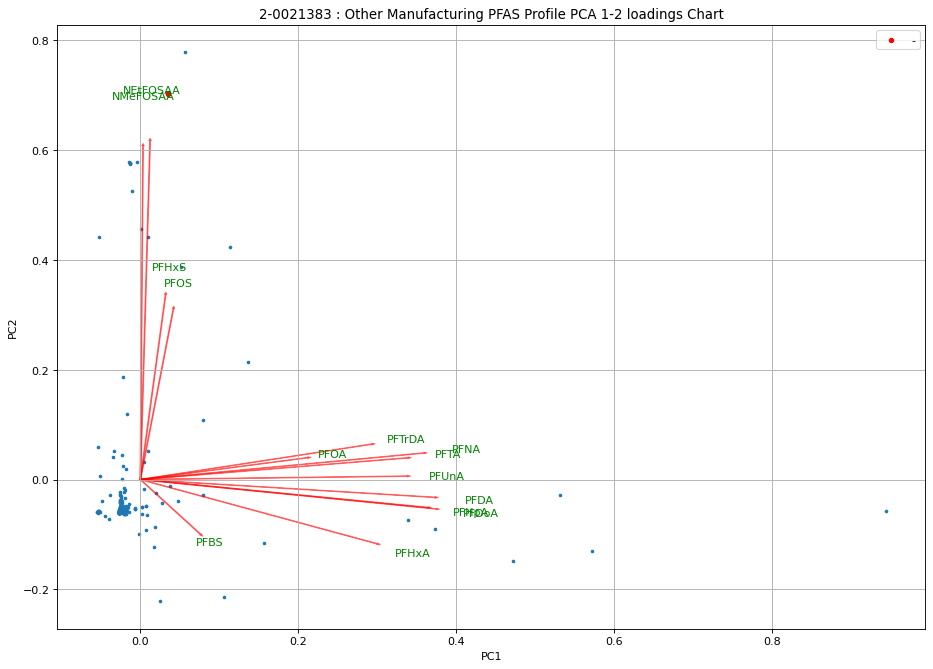

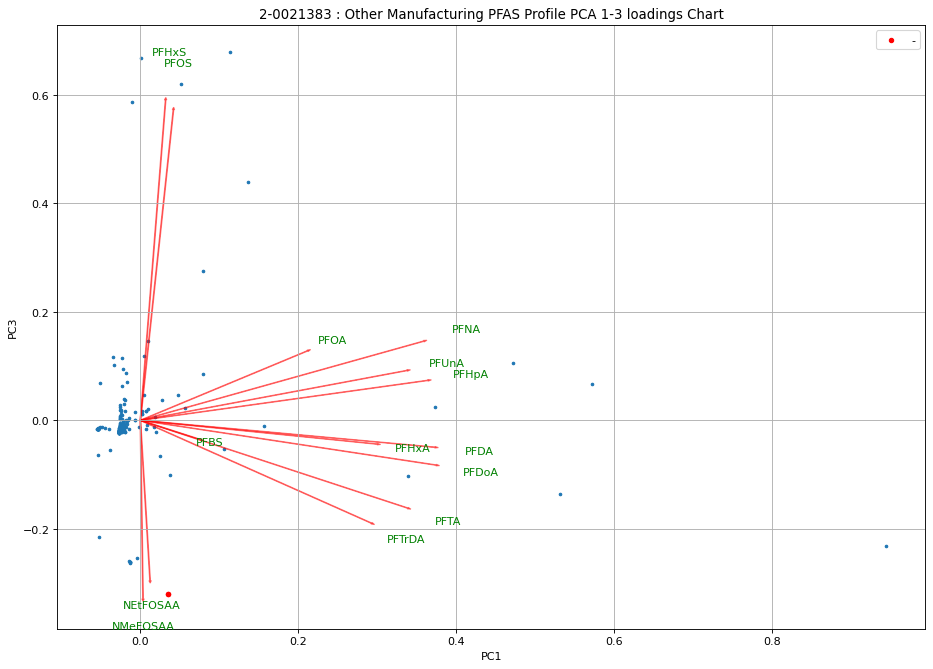

2-0021446
PC 1 Score Summary Statistics : count    2.000000
mean    -0.024823
std      0.001570
min     -0.025933
25%     -0.025378
50%     -0.024823
75%     -0.024268
max     -0.023713
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    2.000000
mean    -0.001476
std      0.065749
min     -0.047968
25%     -0.024722
50%     -0.001476
75%      0.021770
max      0.045015
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    2.000000
mean     0.055448
std      0.084895
min     -0.004582
25%      0.025433
50%      0.055448
75%      0.085463
max      0.115478
Name: PC 3, dtype: float64


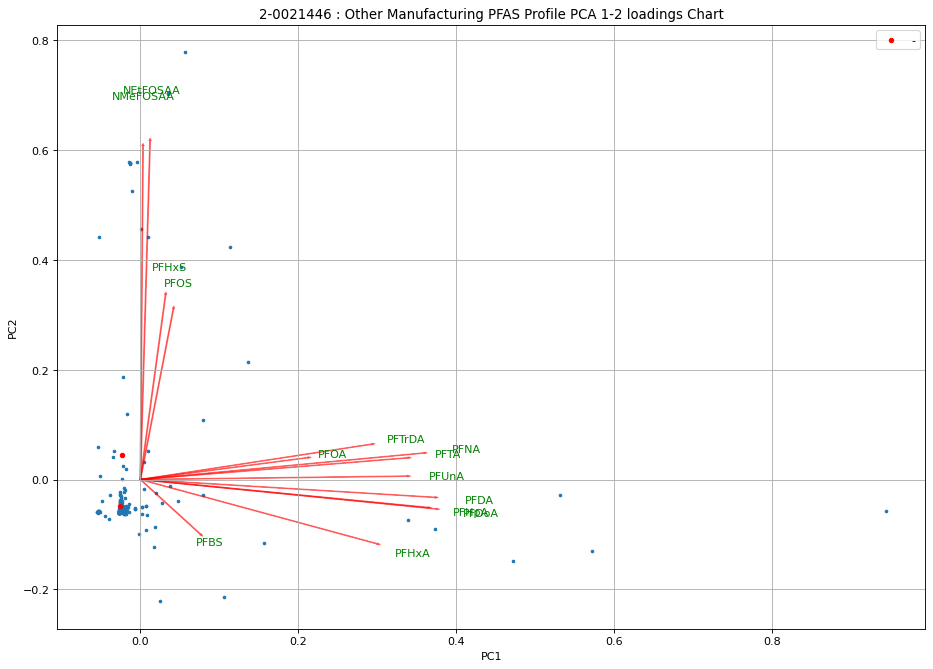

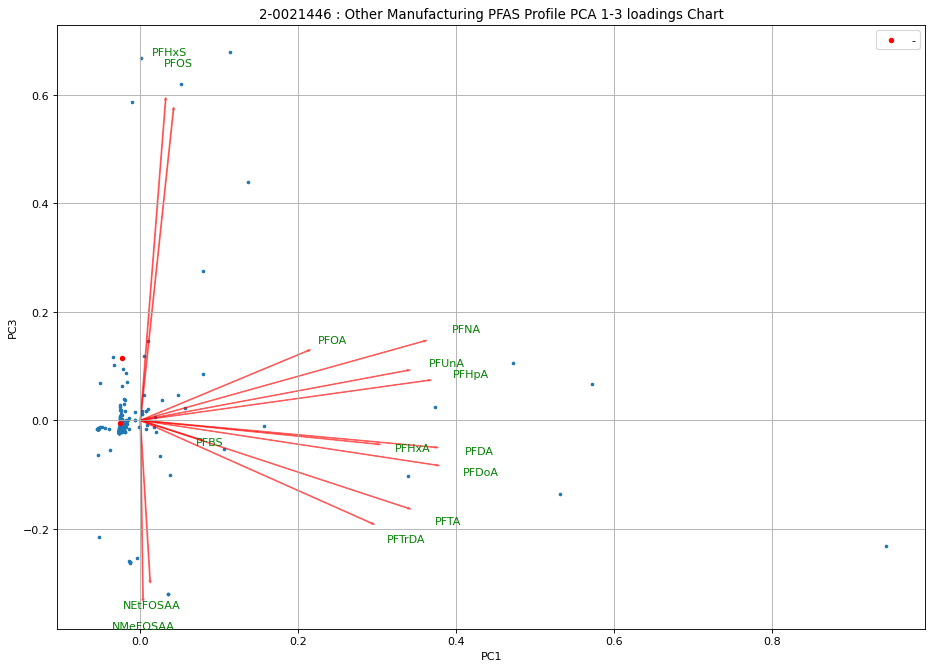

2-0021455
PC 1 Score Summary Statistics : count    5.000000
mean     0.005774
std      0.061191
min     -0.027244
25%     -0.026477
50%     -0.025205
75%     -0.006333
max      0.114129
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    5.000000
mean     0.044543
std      0.211708
min     -0.054308
25%     -0.052655
50%     -0.052450
75%     -0.041012
max      0.423138
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    5.000000
mean     0.134071
std      0.304862
min     -0.014187
25%     -0.013782
50%      0.003868
75%      0.015491
max      0.678965
Name: PC 3, dtype: float64


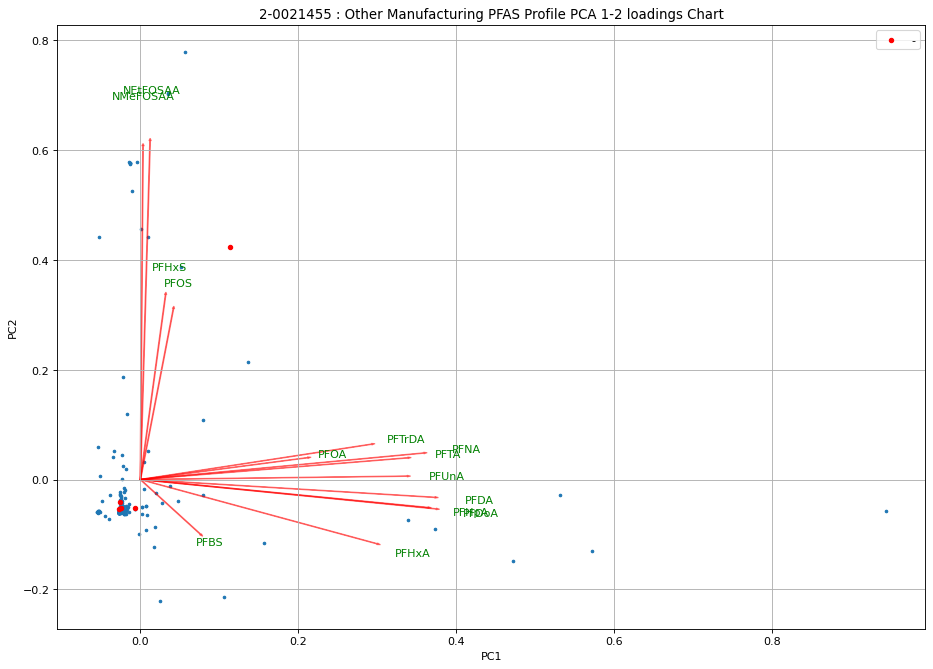

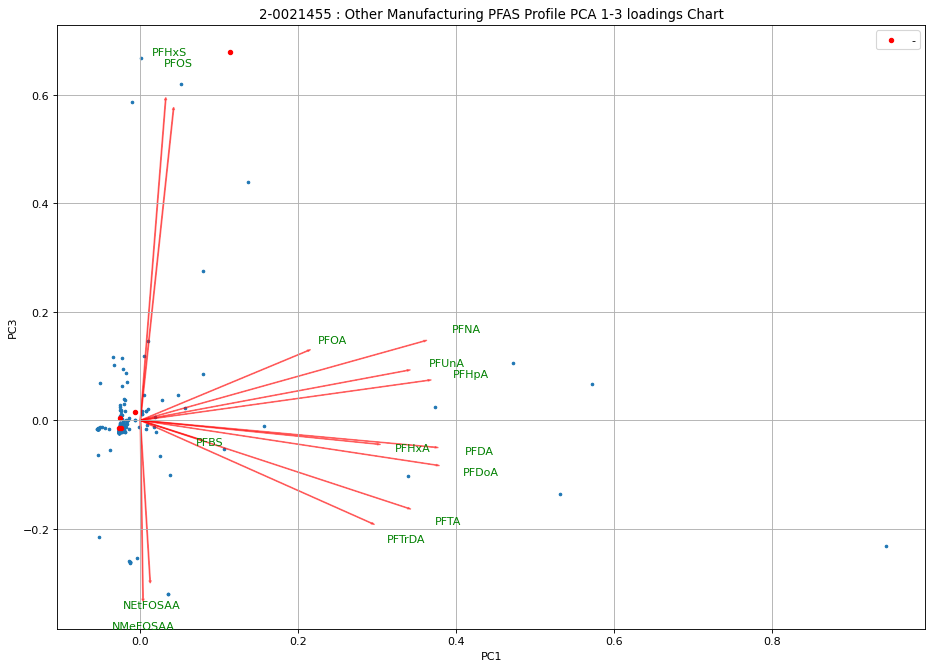

2-0021541
PC 1 Score Summary Statistics : count    17.000000
mean     -0.024672
std       0.003494
min      -0.027554
25%      -0.026849
50%      -0.026560
75%      -0.022631
max      -0.014705
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    17.000000
mean     -0.058514
std       0.002607
min      -0.060871
25%      -0.059996
50%      -0.059372
75%      -0.057043
max      -0.050466
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    17.000000
mean     -0.018423
std       0.004130
min      -0.022644
25%      -0.021300
50%      -0.019592
75%      -0.016617
max      -0.007437
Name: PC 3, dtype: float64


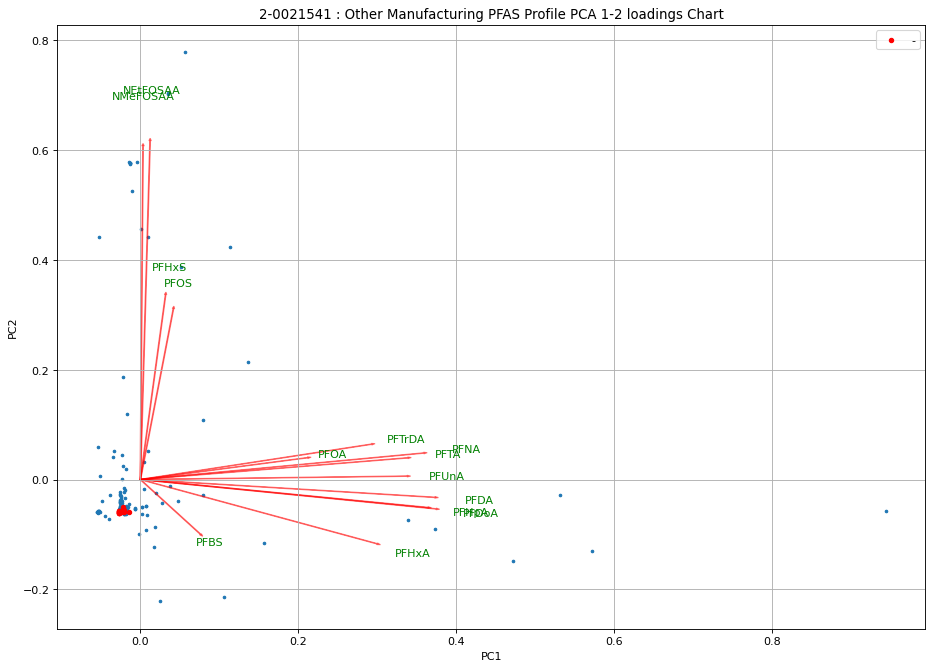

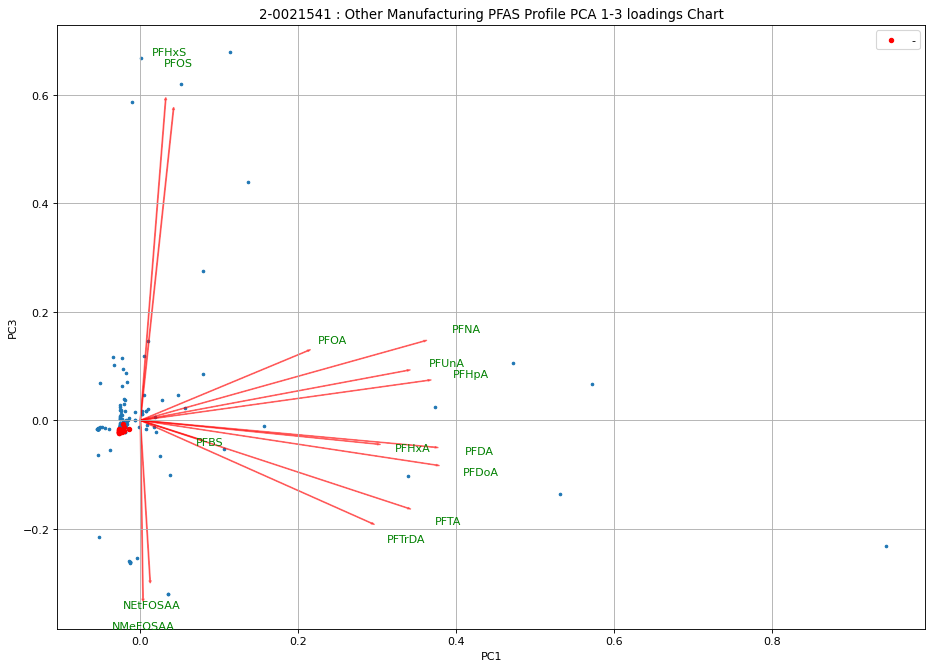

3-0036649
PC 1 Score Summary Statistics : count    30.000000
mean     -0.024177
std       0.018611
min      -0.054001
25%      -0.027182
50%      -0.024717
75%      -0.021233
max       0.051311
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    30.000000
mean      0.026059
std       0.172746
min      -0.060350
25%      -0.056770
50%      -0.046439
75%      -0.016062
max       0.525295
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    30.000000
mean      0.061898
std       0.198119
min      -0.215761
25%      -0.016137
50%      -0.007437
75%       0.035437
max       0.668860
Name: PC 3, dtype: float64


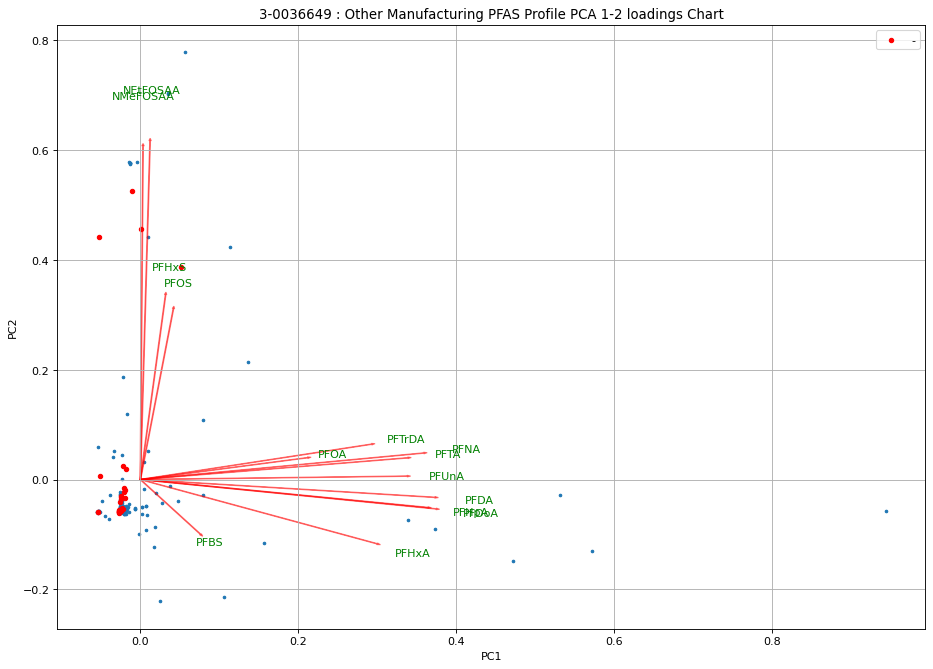

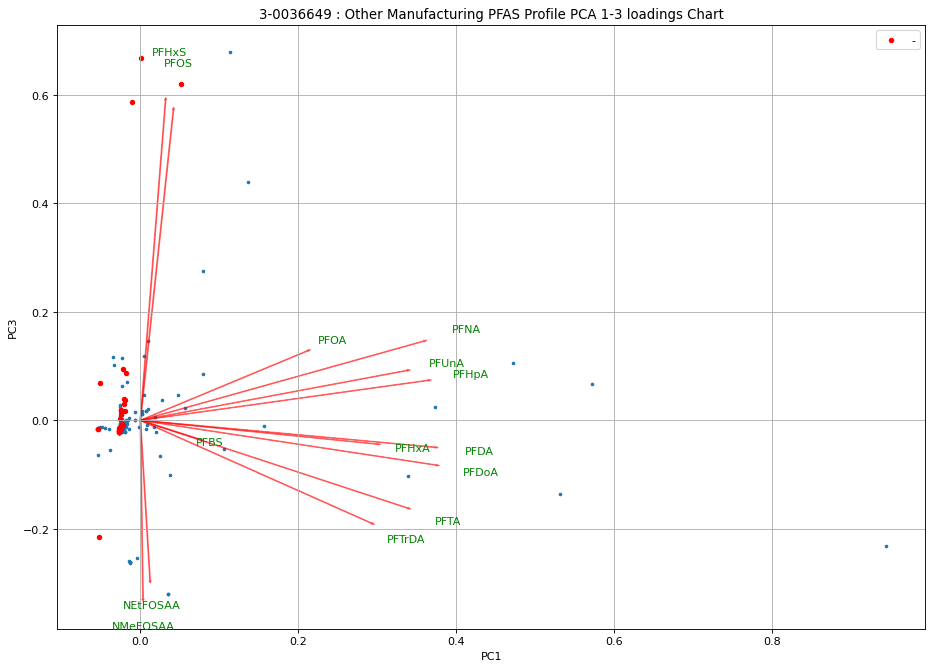

3-0036899
PC 1 Score Summary Statistics : count    23.000000
mean      0.146633
std       0.263777
min      -0.053630
25%      -0.018669
50%       0.017086
75%       0.248111
max       0.944597
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    23.000000
mean     -0.089530
std       0.050954
min      -0.221822
25%      -0.107094
50%      -0.072168
75%      -0.061244
max      -0.024684
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    23.000000
mean     -0.023470
std       0.066054
min      -0.230850
25%      -0.021946
50%      -0.014810
75%      -0.000856
max       0.106191
Name: PC 3, dtype: float64


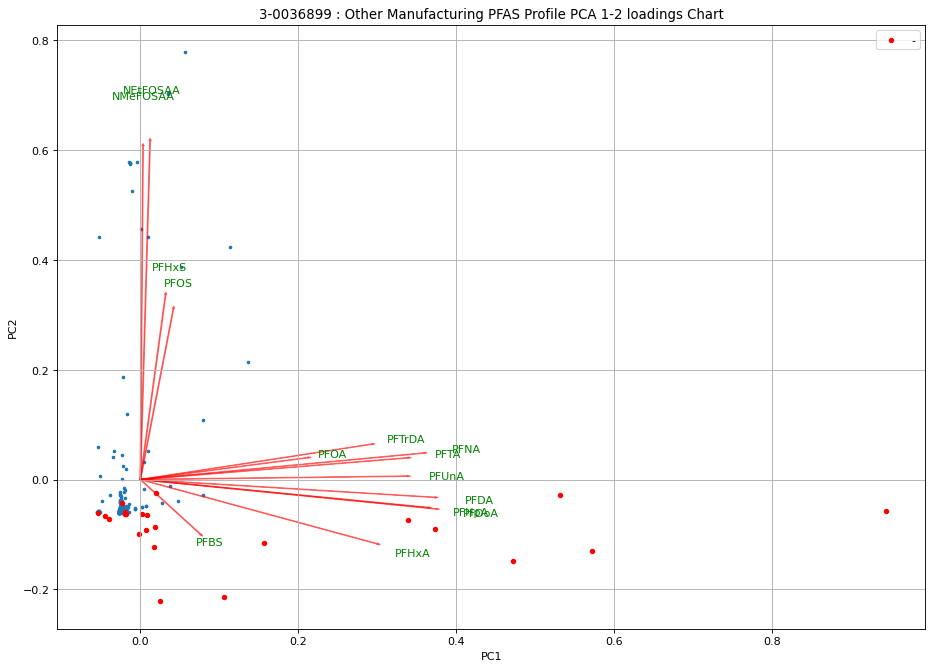

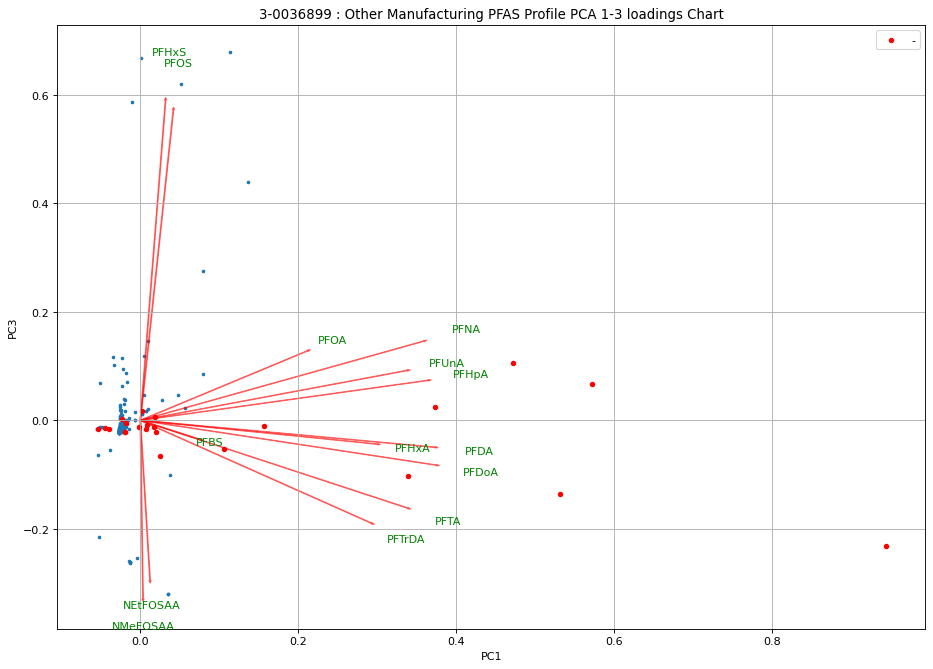

3-0036926
PC 1 Score Summary Statistics : count    17.000000
mean     -0.022457
std       0.003998
min      -0.026746
25%      -0.025716
50%      -0.022854
75%      -0.020498
max      -0.014862
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    17.000000
mean     -0.050464
std       0.010651
min      -0.061117
25%      -0.058336
50%      -0.052995
75%      -0.048499
max      -0.022044
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    17.000000
mean     -0.005892
std       0.013982
min      -0.022231
25%      -0.016180
50%      -0.008775
75%      -0.000146
max       0.028769
Name: PC 3, dtype: float64


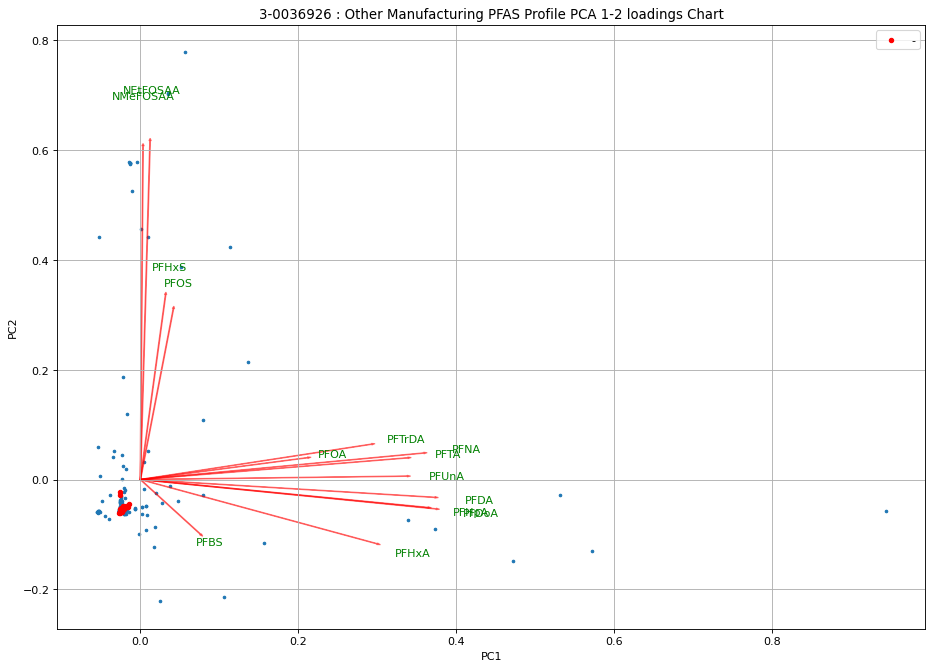

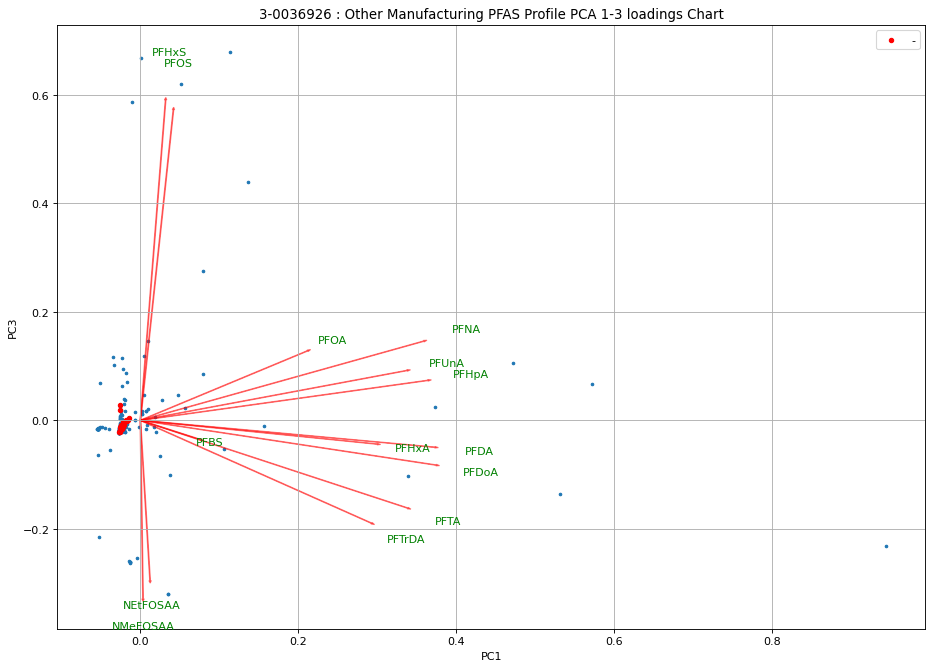

4-0028330
PC 1 Score Summary Statistics : count    25.000000
mean     -0.016343
std       0.046896
min      -0.055403
25%      -0.053776
50%      -0.025802
75%       0.004473
max       0.136610
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    25.000000
mean      0.047455
std       0.189838
min      -0.060579
25%      -0.057533
50%      -0.029028
75%       0.052188
max       0.778178
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    25.000000
mean      0.044622
std       0.111154
min      -0.063113
25%      -0.015968
50%       0.006819
75%       0.071333
max       0.439017
Name: PC 3, dtype: float64


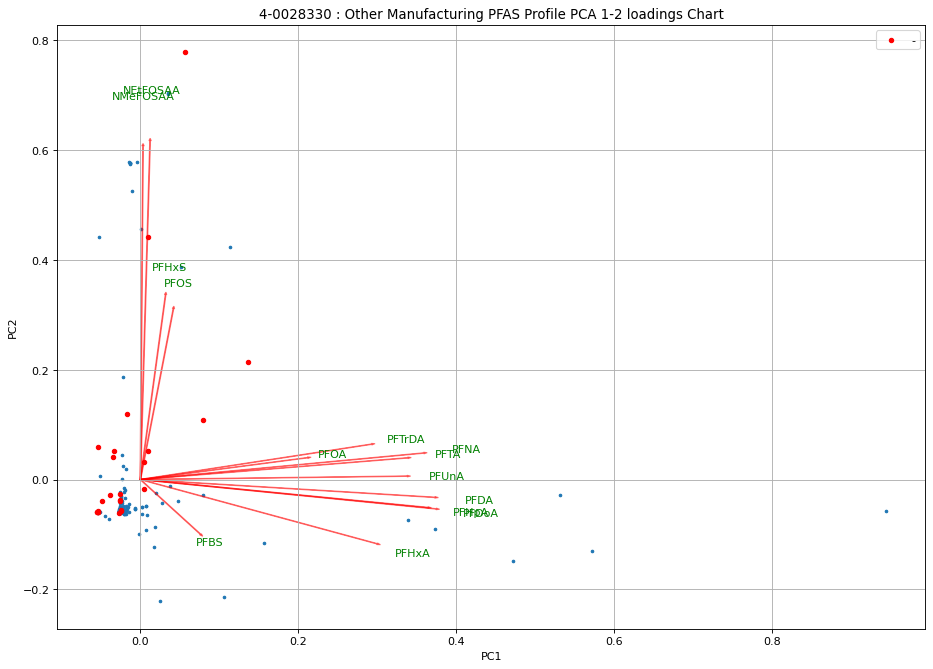

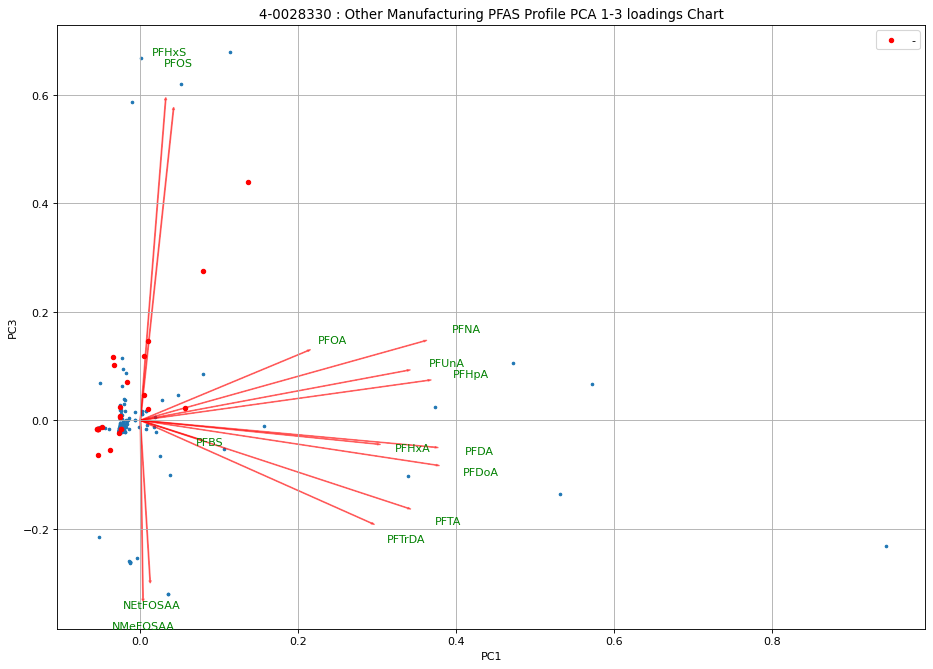

2-0021682
PC 1 Score Summary Statistics : count    10.000000
mean     -0.053289
std       0.001097
min      -0.054004
25%      -0.054002
50%      -0.053869
75%      -0.052848
max      -0.050741
Name: PC 1, dtype: float64
PC 2 Score Summary Statistics : count    10.000000
mean     -0.058387
std       0.000329
min      -0.058677
25%      -0.058647
50%      -0.058548
75%      -0.058183
max      -0.057833
Name: PC 2, dtype: float64
PC 3 Score Summary Statistics : count    10.000000
mean     -0.015010
std       0.000969
min      -0.015826
25%      -0.015785
50%      -0.015357
75%      -0.014331
max      -0.013040
Name: PC 3, dtype: float64


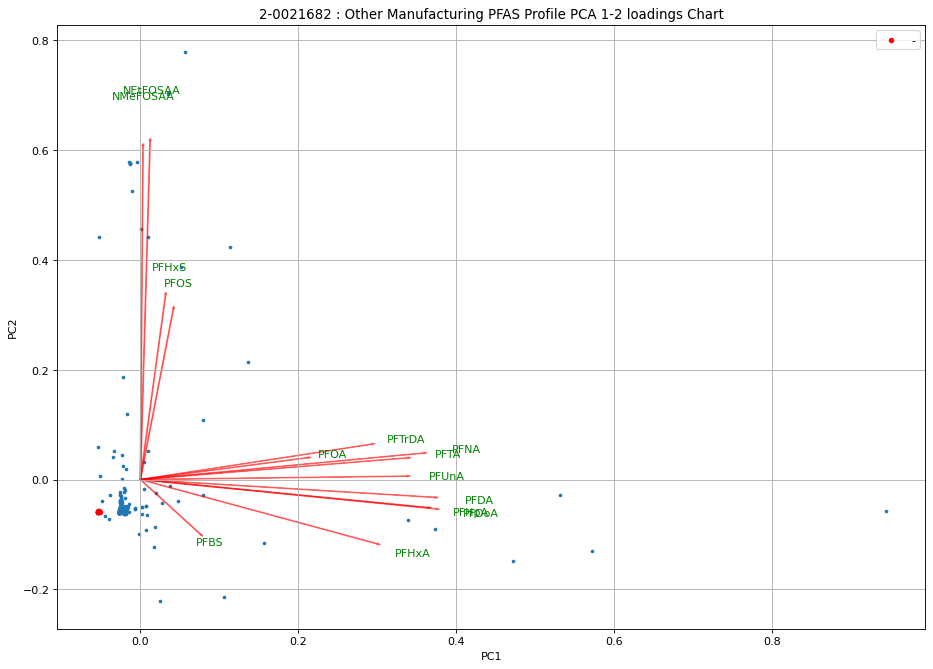

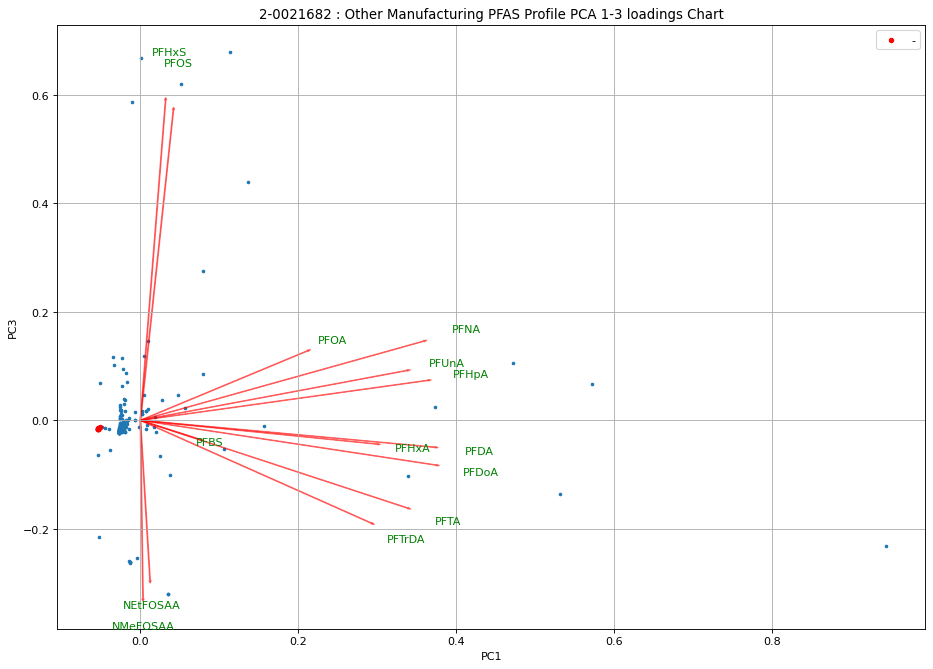

In [30]:
# Run PCA loading plot again. Then overlay scatter plot depicting samples for each cluster onto the loading plot.
for rtn in other_df['RTN'].unique():
    
    y_rtn_pca = pca_df[pca_df['RTN']==rtn]
    y_rtn_pca_x = y_rtn_pca.iloc[:,0]
    y_rtn_pca_y = y_rtn_pca.iloc[:,1]
    y_rtn_pca_z = y_rtn_pca.iloc[:,2]
    
    print(rtn)
    print('PC 1 Score Summary Statistics :', (y_rtn_pca_x * scalex).describe())
    print('PC 2 Score Summary Statistics :', (y_rtn_pca_y * scaley).describe())
    print('PC 3 Score Summary Statistics :', (y_rtn_pca_z * scalez).describe())
    
    utils.pca_loadings_plot(Principal_components[:,0:2],np.transpose(pca.components_[0:2, :]),list(other_df[pfas_vars].columns), title = f"{rtn} : Other Manufacturing PFAS Profile PCA 1-2 loadings Chart")
    
    plt.scatter(y_rtn_pca_x * scalex, y_rtn_pca_y * scaley, s=15, c='red', label=f'{rtn[1]}')
        
    plt.legend()
    plt.show()

    utils.pca_loadings_plot(Principal_components[:,(0,2)],np.transpose(pca.components_[(0,2), :]),list(other_df[pfas_vars].columns), title = f"{rtn} : Other Manufacturing PFAS Profile PCA 1-3 loadings Chart")


    plt.scatter(y_rtn_pca_x * scalex, y_rtn_pca_z * scalez, s=15, c='red', label=f'{rtn[1]}')
    plt.ylabel("PC{}".format(3))

    plt.legend()
    plt.show()

PC 1 - Mixed Industrial Applications. Consistent with RTNs and with URI MVA study

****

### Hierarchical Clustering (HC)
* HC via "Ward" method and euclidean distance.
* Ward method minimizes within-cluster variance.

In [21]:
# other_df.head(50)

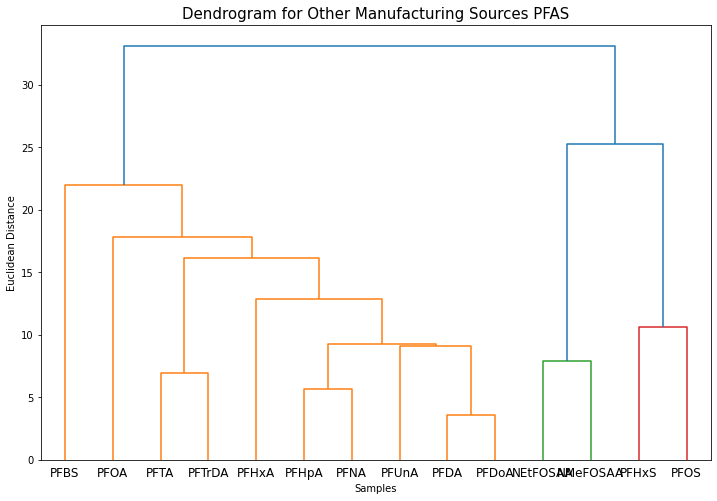

In [42]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(12, 8))
dend = shc.dendrogram(shc.linkage(other_df[pfas_vars].T, method='ward'), labels = other_df[pfas_vars].T.index)
plt.title("Dendrogram for Other Manufacturing Sources PFAS", fontsize=15)
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()

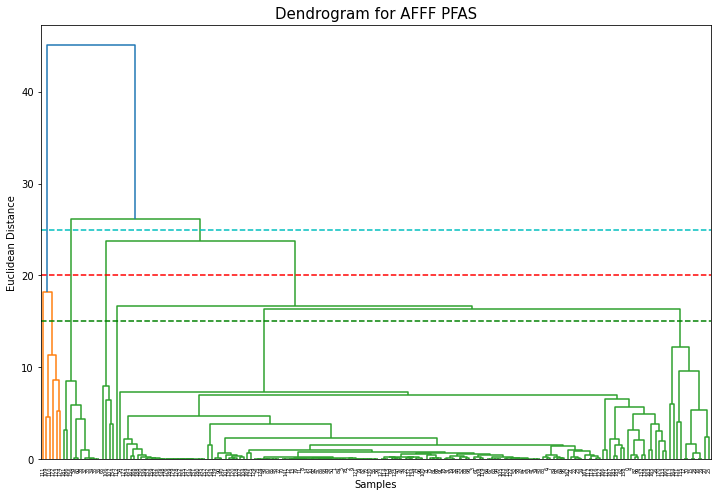

In [23]:
# Determine the optimal # of clusters using the dendrogram.
# Look for the longest vertical line(s) that does not cross another horizontal line.
# That would be the blue line on the left. Hence, if we choose a Euclidean distance
# of 4, we would get three (3) clusters (see cyan dotted line below).
plt.figure(figsize=(12, 8))
dend = shc.dendrogram(shc.linkage(other_df[pfas_vars], method='ward'))
plt.title("Dendrogram for AFFF PFAS", fontsize=15)
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.axhline(y=25, color='c', linestyle='--')
# Other lines, but might be overkill.
plt.axhline(y=20, color='r', linestyle='--')
plt.axhline(y=15, color='g', linestyle='--')
# plt.axhline(y=2.25, color='b', linestyle='--')
plt.show()

In [24]:
# Predict clusters using agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

numClusters = 4
# Based on analysis of dendrogram above, we will select three (3) clusters.
clusterHC = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='ward')  
y_hc = clusterHC.fit_predict(other_df[pfas_vars])

In [25]:
# Visualize clusters in 2D scatter plot. Can only pick up to three compounds at a time,
# but will only plot the first two on the list for 2D scatter plot.
# test = cluster.labels_
y_hc_loc0 = other_df.iloc[y_hc==0]
y_hc_loc1 = other_df.iloc[y_hc==1]
y_hc_loc2 = other_df.iloc[y_hc==2]
y_hc_loc3 = other_df.iloc[y_hc==3]

pfas_col_num = [5, 10, 11]
pfas_col_names = [pfas_vars[i] for i in pfas_col_num]
# print(pfas_names)

data0 = y_hc_loc0[pfas_col_names]
data1 = y_hc_loc1[pfas_col_names]
data2 = y_hc_loc2[pfas_col_names]
data3 = y_hc_loc3[pfas_col_names]
# print(data0)

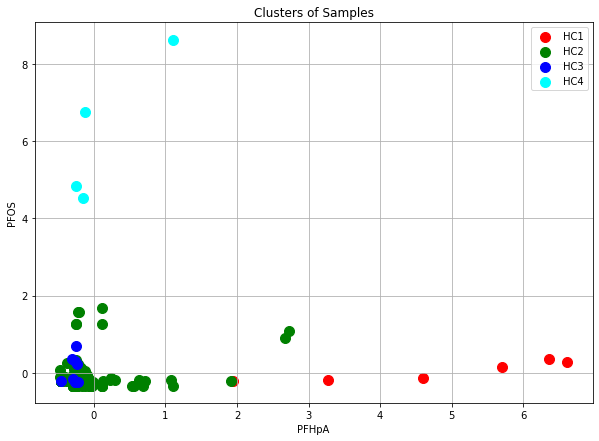

In [26]:
# Plot clusters in 2D
plt.figure(figsize=(10, 7))

# plt.scatter(data0, data1, data2, c=clusterHC.labels_)
plt.scatter(data0.iloc[:, 0], data0.iloc[:, 1], s=100, c='red', label='HC1')
plt.scatter(data1.iloc[:, 0], data1.iloc[:, 1], s=100, c='green', label='HC2')
plt.scatter(data2.iloc[:, 0], data2.iloc[:, 1], s=100, c='blue', label='HC3')
plt.scatter(data3.iloc[:, 0], data3.iloc[:, 1], s=100, c='cyan', label='HC4')

plt.title("Clusters of Samples")
plt.xlabel(pfas_col_names[0])
plt.ylabel(pfas_col_names[1])
plt.legend()
plt.grid(True)

plt.show()

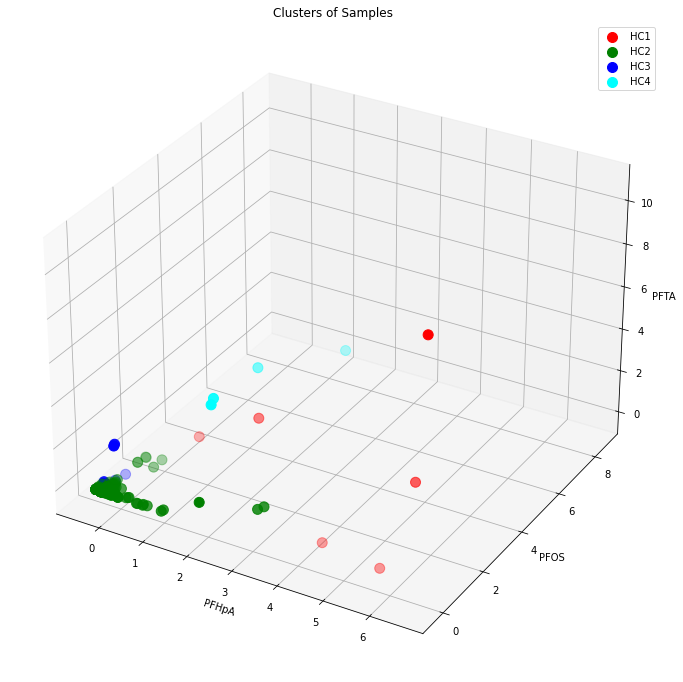

In [27]:
# Plot clusters in 3D
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection ="3d")

# plt.scatter(data0, data1, data2, c=clusterHC.labels_)
ax.scatter3D(data0.iloc[:, 0], data0.iloc[:, 1], data0.iloc[:, 2], s=100, c='red', label='HC1')
ax.scatter3D(data1.iloc[:, 0], data1.iloc[:, 1], data1.iloc[:, 2], s=100, c='green', label='HC2')
ax.scatter3D(data2.iloc[:, 0], data2.iloc[:, 1], data2.iloc[:, 2], s=100, c='blue', label='HC3')
ax.scatter3D(data3.iloc[:, 0], data3.iloc[:, 1], data3.iloc[:, 2], s=100, c='cyan', label='HC4')

plt.title("Clusters of Samples")
plt.legend()
ax.set_xlabel(pfas_col_names[0])
ax.set_ylabel(pfas_col_names[1])
ax.set_zlabel(pfas_col_names[2])

plt.show()

In [28]:
# Set up box and whisker plots for each cluster for visualizing the profiles.
pfas_col_num = np.arange(len(pfas_vars))
pfas_col_names = [pfas_vars[i] for i in pfas_col_num]
# print(pfas_col_names)

# median_cluster0 = y_hc_loc0[pfas_col_names].median(axis=0)
# median_cluster1 = y_hc_loc1[pfas_col_names].median(axis=0)
# median_cluster2 = y_hc_loc2[pfas_col_names].median(axis=0)

# mean_cluster0 = y_hc_loc0[pfas_col_names].mean(axis=0)
# mean_cluster1 = y_hc_loc1[pfas_col_names].mean(axis=0)
# mean_cluster2 = y_hc_loc2[pfas_col_names].mean(axis=0)

# print(median_cluster0)
# print(mean_cluster0)
# print(y_hc_loc2[pfas_col_names].max(axis=0))

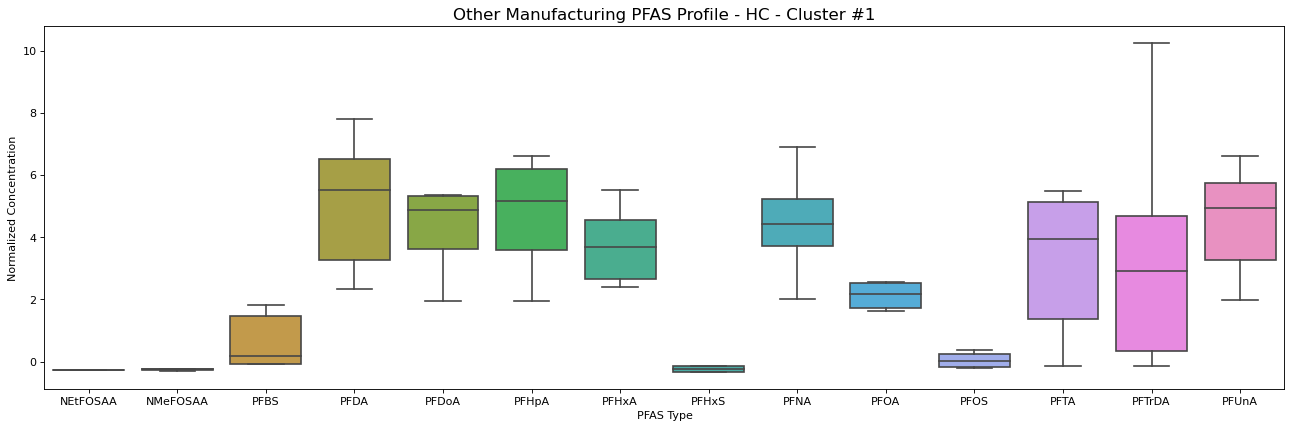

In [29]:
plt.figure(figsize=(20, 6), dpi=80)
# plt.ylabel('Normalized Concentration')
# plt.xlabel('PFAS Type')
plt.title('Other Manufacturing PFAS Profile - HC - Cluster #1', fontsize=15)

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc0[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
# Set all clusters to have the same y-axis scaling (for better comparison)
# plt.ylim(0, 1.05)
plt.show()

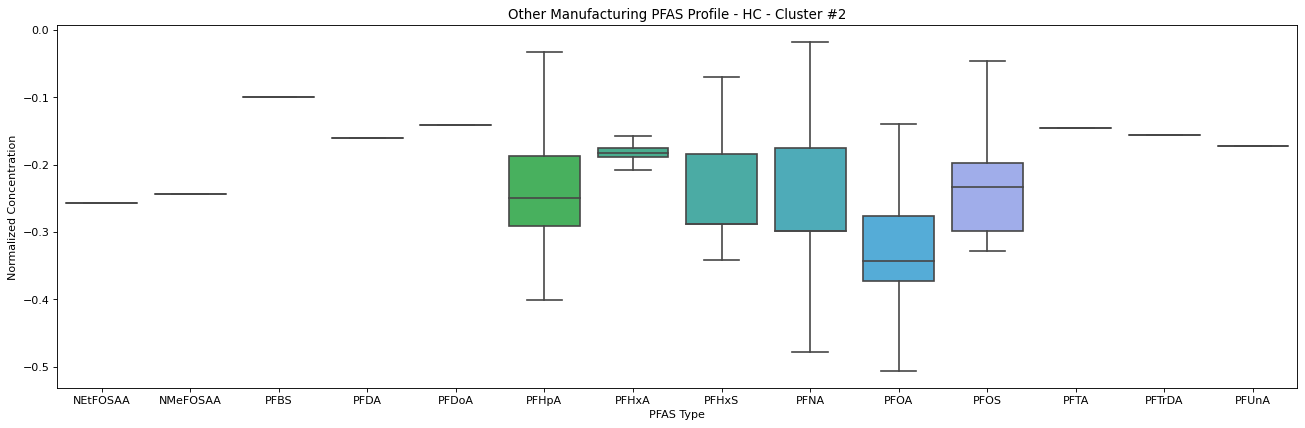

In [30]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Other Manufacturing PFAS Profile - HC - Cluster #2')

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc1[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

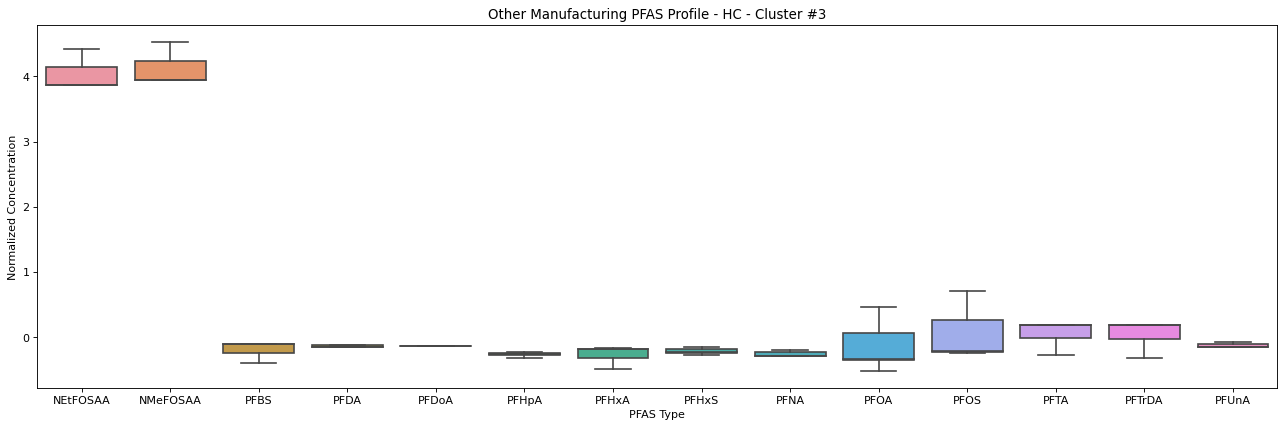

In [31]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Other Manufacturing PFAS Profile - HC - Cluster #3')

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc2[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

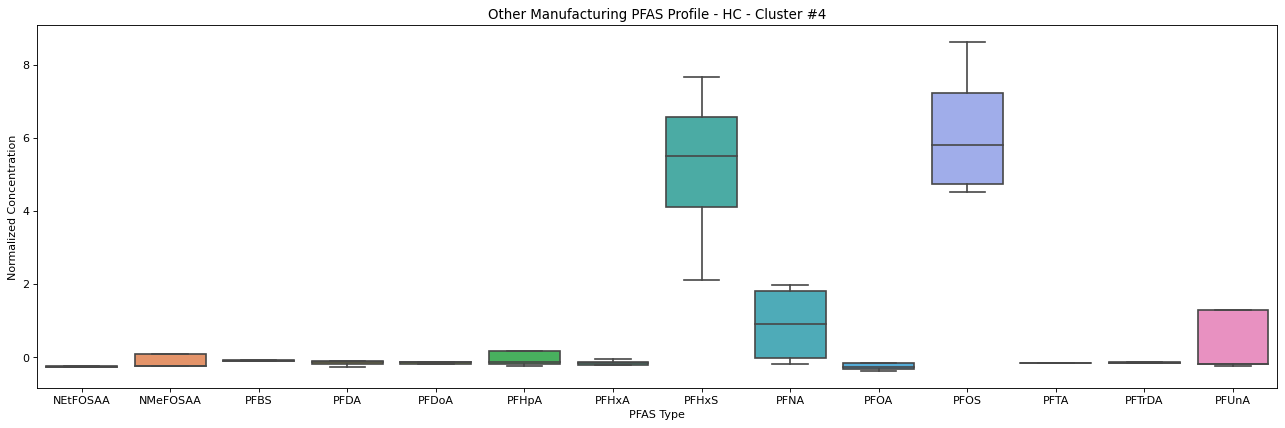

In [32]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('Other Manufacturing PFAS Profile - HC - Cluster #4')

sns.boxplot(x="variable", y="value", data=pd.melt(y_hc_loc3[pfas_col_names]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

****

### Compare PCA to HC
* Overlay samples for each clusters onto the PCA loading plot

In [33]:
# Need to scale values based on ALL values not only those from individual clusters because original
# PCA loading plot is based on all values.
pca_df_x = pca_df.iloc[:,0]
pca_df_y = pca_df.iloc[:,1]
scalex = 1.0/(pca_df_x.max() - pca_df_x.min())
scaley = 1.0/(pca_df_y.max() - pca_df_y.min())

y_hc_loc0_pca = pca_df.iloc[y_hc==0]
y_hc_loc1_pca = pca_df.iloc[y_hc==1]
y_hc_loc2_pca = pca_df.iloc[y_hc==2]
y_hc_loc3_pca = pca_df.iloc[y_hc==3]

# print(type(Principal_components))
# print(type(y_hc_loc0_pca))
y_hc_loc0_pca_x = y_hc_loc0_pca.iloc[:,0]
y_hc_loc0_pca_y = y_hc_loc0_pca.iloc[:,1]
y_hc_loc1_pca_x = y_hc_loc1_pca.iloc[:,0]
y_hc_loc1_pca_y = y_hc_loc1_pca.iloc[:,1]
y_hc_loc2_pca_x = y_hc_loc2_pca.iloc[:,0]
y_hc_loc2_pca_y = y_hc_loc2_pca.iloc[:,1]
y_hc_loc3_pca_x = y_hc_loc3_pca.iloc[:,0]
y_hc_loc3_pca_y = y_hc_loc3_pca.iloc[:,1]
# print(y_hc_loc0_pca_x)
# print(y_hc_loc0_pca_y)
# y_hc_loc0_pca_x = y_hc_loc0_pca['PC1']
# y_hc_loc0_pca_y = y_hc_loc0_pca[:,1]

# print(scalex)
# print(scaley)
# print(y_hc_loc0_pca_x * scalex)
# print(y_hc_loc0_pca_y * scaley)

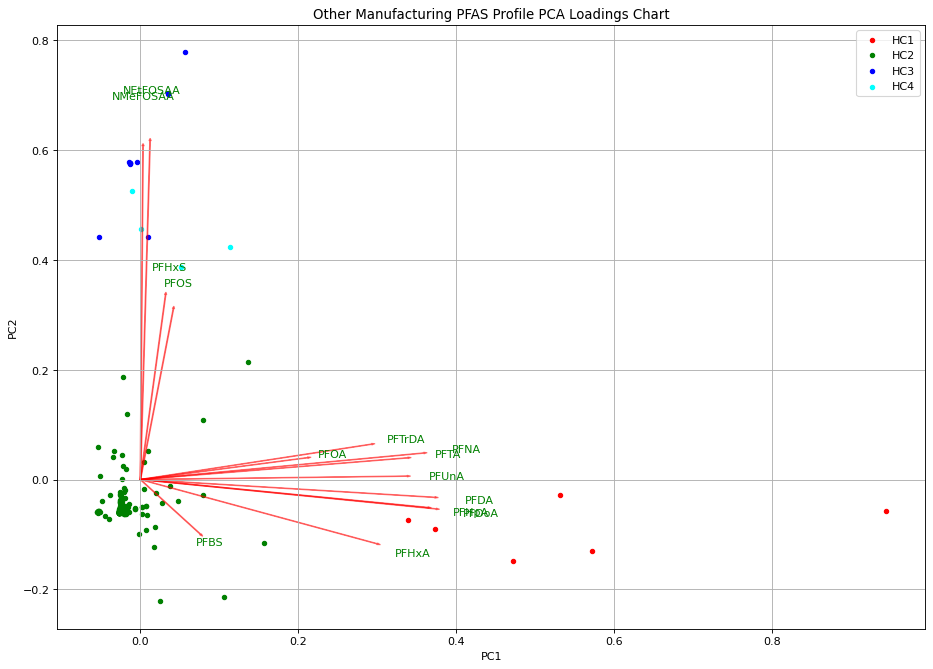

In [34]:
# Run PCA loading plot again. Then overlay scatter plot depicting samples for each cluster onto the loading plot.
utils.pca_loadings_plot(Principal_components[:,0:2],np.transpose(pca.components_[0:2, :]),list(other_df[pfas_vars].columns), title = "Other Manufacturing PFAS Profile PCA Loadings Chart")
plt.scatter(y_hc_loc0_pca_x * scalex, y_hc_loc0_pca_y * scaley, s=15, c='red', label='HC1')
plt.scatter(y_hc_loc1_pca_x * scalex, y_hc_loc1_pca_y * scaley, s=15, c='green', label='HC2')
plt.scatter(y_hc_loc2_pca_x * scalex, y_hc_loc2_pca_y * scaley, s=15, c='blue', label='HC3')
plt.scatter(y_hc_loc3_pca_x * scalex, y_hc_loc3_pca_y * scaley, s=15, c='cyan', label='HC4')
plt.legend()
plt.show()

****

### Spatial Inference of Hierarchical Cluster
* Create layer of locations by cluster

In [35]:
source_locations = pd.read_parquet('../../../data/disposal_sites/PFAS_Sites_2021-11-07_geocoded.parquet')

In [36]:
other_df['hclusters'] = y_hc

In [37]:
other_df['RTN'] = utils.extract_rtn(df = other_df,
                                    report_col = 'report')

In [38]:
other_df = other_df.merge(source_locations[['RTN', 'lat', 'lon']], on = 'RTN')

In [39]:
other_df = utils.add_wiggliness_for_spatial_interpolation(df = other_df,
                                                          lat_col = 'lat',
                                                          lon_col = 'lon')

In [40]:
other_gdf = gpd.GeoDataFrame(
    other_df, 
    geometry=gpd.points_from_xy(other_df.lon, other_df.lat),
    crs={"init":"EPSG:4326"})

C:\Users\dcher\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [41]:
# other_gdf.to_file('../../data/modeling_data/source_attribution/profiling/other_clusters.geojson', driver = 'GeoJSON')